<a href="https://colab.research.google.com/github/emseekim/03_team_project/blob/main/AI06_3%E1%84%90%E1%85%B5%E1%86%B7_%E1%84%91%E1%85%B3%E1%84%85%E1%85%A9%E1%84%8C%E1%85%A6%E1%86%A8%E1%84%90%E1%85%B3_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI 기반 경구약제 객체 탐지**

## **1. 프로젝트 개요**

### **1.1 문제 정의 및 목표**
- 스마트폰으로 촬영된 알약 이미지에서 약의 종류(Class)와 위치(Bounding Box)를 동시에 탐지하는 모델 개발.
- Kaggle 데이터(AI Hub 원천) 구조 파악 및 학습 파이프라인 구축
- 알약 객체 탐지 및 30종 상비약 서비스 정보 매핑

### **1.2 데이터셋 소개**
- Ai hub 경구약제 이미지 데이터를 가공한 데이터 (COCO Format JSON + Images)

## **2. 환경 설정 및 데이터 준비**

### **2.1 라이브러리 로드 & 장치(GPU) 설정**

In [ ]:
import os
import random
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current Device: {device}")

# 한글 폰트(나눔글꼴) 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Seed set to 42
Current Device: cuda
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,945 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Readin

### **2.2 데이터 다운로드**

In [ ]:
import os
from google.colab import files

# ⭐ 핵심: 데이터 폴더가 실제로 있는지 먼저 확인!
# (폴더가 있으면 아래 모든 과정을 건너뜁니다)
if os.path.exists('./data/train_images'):
    print("✅ 데이터가 이미 준비되어 있습니다! (다운로드 및 업로드 건너뜀)")

else:
    print("🚀 데이터가 없습니다. 다운로드를 위해 kaggle.json 업로드를 시작합니다...")

    # 1. 기존 설정 초기화
    !rm -f kaggle.json
    !rm -rf ~/.kaggle

    print("'kaggle.json'을 선택해주세요!")
    uploaded = files.upload() # <--- 데이터가 없을 때만 실행됨

    # 2. 파일 이동 및 권한 설정
    if 'kaggle.json' in uploaded.keys():
        print("✅ 파일 업로드 성공! 인증을 진행합니다.")
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

        # 3. 다운로드 및 압축 해제
        print("🚀 데이터 다운로드 시작...")
        !kaggle competitions download -c ai06-level1-project

        print("📂 압축 해제 중...")
        !unzip -q ai06-level1-project.zip -d ./data
        print("🎉 데이터 준비 완료! (./data 폴더)")

    else:
        print("❌ 파일 업로드가 취소되었습니다.")

✅ 데이터가 이미 준비되어 있습니다! (다운로드 및 업로드 건너뜀)


In [ ]:
# from google.colab import files

# # 1. 기존 파일 삭제 (꼬임 방지)
# !rm -f kaggle.json
# !rm -rf ~/.kaggle

# print("'kaggle.json'을 선택해주세요!")
# uploaded = files.upload() # <--- 여기서 파일 선택 창이 뜹니다!

# # 2. 파일 이동 및 권한 설정
# if 'kaggle.json' in uploaded.keys():
#     print("✅ 파일 업로드 성공! 인증을 진행합니다.")
#     !mkdir -p ~/.kaggle
#     !mv kaggle.json ~/.kaggle/
#     !chmod 600 ~/.kaggle/kaggle.json

#     # 3. 다운로드 및 압축 해제
#     if not os.path.exists('./ai06-level1-project.zip'):
#         print("🚀 데이터 다운로드 시작...")
#         !kaggle competitions download -c ai06-level1-project

#         print("📂 압축 해제 중...")
#         !unzip -q ai06-level1-project.zip -d ./data
#         print("🎉 데이터 준비 완료! (./data 폴더)")
#     else:
#         print("이미 다운로드된 데이터가 있습니다.")
# else:
#     print("❌ 파일 업로드가 취소되었습니다.")

### **2.3 구글 드라이브 마운트 및 백업**

In [ ]:
from google.colab import drive
import shutil
import os

# 1. 구글 드라이브 연결 (로그인 창이 뜨면 승인해주세요)
print("📥 구글 드라이브를 연결합니다...")
drive.mount('/content/drive')
MY_BACKUP_FOLDER = "/content/drive/MyDrive/My_AI_Project/team_project"

# 2. 백업 실행
zip_file = './ai06-level1-project.zip'

if os.path.exists(MY_BACKUP_FOLDER):
    if os.path.exists(zip_file):
        print(f"🚀 드라이브로 복사 시작... (약 1~2분 소요)")
        print(f"Source: {zip_file}")
        print(f"Target: {MY_BACKUP_FOLDER}")

        # 파일 복사
        shutil.copy(zip_file, MY_BACKUP_FOLDER)

        print("✅ 백업 완료! 이제 데이터가 드라이브에 안전하게 저장되었습니다.")
    else:
        print("⚠️ 복사할 ZIP 파일이 없습니다. (이미 압축 풀고 원본을 지우셨나요?)")
else:
    print(f"❌ 폴더를 찾을 수 없습니다: {MY_BACKUP_FOLDER}")
    print("경로에 오타가 없는지, 마운트가 잘 되었는지 확인해주세요.")

📥 구글 드라이브를 연결합니다...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 드라이브로 복사 시작... (약 1~2분 소요)
Source: ./ai06-level1-project.zip
Target: /content/drive/MyDrive/My_AI_Project/team_project
✅ 백업 완료! 이제 데이터가 드라이브에 안전하게 저장되었습니다.


### **2.4 분산된 JSON 병합**
- 원본 데이터가 수백 개의 폴더와 파일로 쪼개져 있어 학습 불가
- 해결: 스크립트로 하나로 합쳐서 train.json 생성

In [ ]:
import os
import json
import glob
from tqdm import tqdm

# ==========================================
# 1. 경로 설정 (Config 없이 직접 지정)
# ==========================================
DATA_ROOT = './data'  # 임시 정의
ANNOTATION_ROOT = os.path.join(DATA_ROOT, 'train_annotations')
OUTPUT_JSON = os.path.join(DATA_ROOT, 'train.json')

print(f"📂 검색 경로: {ANNOTATION_ROOT}")

# 2. 흩어진 모든 .json 파일 찾기 (재귀 탐색)
json_files = glob.glob(os.path.join(ANNOTATION_ROOT, '**', '*.json'), recursive=True)
print(f"🔍 발견된 JSON 파일 개수: {len(json_files)}개")

# 3. 데이터 병합 (Merging)
merged_data = {
    "images": [],
    "annotations": [],
    "categories": []
}

# 중복 방지용 Set
seen_category_ids = set()
seen_image_ids = set()

print("🚀 병합 시작...")

for json_path in tqdm(json_files):
    with open(json_path, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)

            # (1) Images 병합
            for img in data.get('images', []):
                if img['id'] not in seen_image_ids:
                    merged_data['images'].append(img)
                    seen_image_ids.add(img['id'])

            # (2) Annotations 병합
            if 'annotations' in data:
                merged_data['annotations'].extend(data['annotations'])

            # (3) Categories 병합
            for cat in data.get('categories', []):
                if cat['id'] not in seen_category_ids:
                    merged_data['categories'].append(cat)
                    seen_category_ids.add(cat['id'])

        except json.JSONDecodeError:
            print(f"⚠️ 에러: 깨진 파일 건너뜀 - {json_path}")

# 4. 결과 저장
with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
    json.dump(merged_data, f, ensure_ascii=False)

print("-" * 30)
print(f"🎉 병합 완료!")
print(f"💾 저장 위치: {OUTPUT_JSON}")
print(f"- 총 이미지: {len(merged_data['images'])}")
print(f"- 총 박스(Annotations): {len(merged_data['annotations'])}")
print(f"- 총 알약 종류(Categories): {len(merged_data['categories'])}")
print("-" * 30)

📂 검색 경로: ./data/train_annotations
🔍 발견된 JSON 파일 개수: 1001개
🚀 병합 시작...


100%|██████████| 1001/1001 [00:00<00:00, 2595.66it/s]


------------------------------
🎉 병합 완료!
💾 저장 위치: ./data/train.json
- 총 이미지: 369
- 총 박스(Annotations): 1001
- 총 알약 종류(Categories): 56
------------------------------


In [ ]:
# import os
# import json
# import glob
# from tqdm import tqdm

# # 1. 경로 설정
# # Config 클래스에 있는 경로를 그대로 씁니다.
# ANNOTATION_ROOT = os.path.join(Config.DATA_ROOT, 'train_annotations')
# OUTPUT_JSON = os.path.join(Config.DATA_ROOT, 'train.json')  # 루트에 바로 저장

# print(f"📂 검색 경로: {ANNOTATION_ROOT}")

# # 2. 흩어진 모든 .json 파일 찾기 (재귀 탐색)
# # 폴더 깊숙이 있는 것까지 다 찾아냅니다.
# json_files = glob.glob(os.path.join(ANNOTATION_ROOT, '**', '*.json'), recursive=True)
# print(f"🔍 발견된 JSON 파일 개수: {len(json_files)}개")

# # 3. 데이터 병합 (Merging)
# merged_data = {
#     "images": [],
#     "annotations": [],
#     "categories": []
# }

# # 카테고리 중복 방지용 Set
# seen_category_ids = set()
# # 이미지 ID 중복 방지용 (혹시 몰라서)
# seen_image_ids = set()

# print("🚀 병합 시작...")

# for json_path in tqdm(json_files):
#     with open(json_path, 'r', encoding='utf-8') as f:
#         try:
#             data = json.load(f)

#             # (1) Images 병합
#             for img in data.get('images', []):
#                 if img['id'] not in seen_image_ids:
#                     merged_data['images'].append(img)
#                     seen_image_ids.add(img['id'])

#             # (2) Annotations 병합
#             if 'annotations' in data:
#                 merged_data['annotations'].extend(data['annotations'])

#             # (3) Categories 병합
#             for cat in data.get('categories', []):
#                 if cat['id'] not in seen_category_ids:
#                     merged_data['categories'].append(cat)
#                     seen_category_ids.add(cat['id'])

#         except json.JSONDecodeError:
#             print(f"⚠️ 에러: 깨진 파일 건너뜀 - {json_path}")

# # 4. 결과 저장
# with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
#     json.dump(merged_data, f, ensure_ascii=False)

# # 5. Config 경로 업데이트 (이제 이 파일을 씁니다!)
# Config.TRAIN_JSON = OUTPUT_JSON

# print("-" * 30)
# print(f"🎉 병합 완료!")
# print(f"💾 저장 위치: {OUTPUT_JSON}")
# print(f"- 총 이미지: {len(merged_data['images'])}")
# print(f"- 총 박스(Annotations): {len(merged_data['annotations'])}")
# print(f"- 총 알약 종류(Categories): {len(merged_data['categories'])}")
# print("-" * 30)

### **2.5 경로 및 하이퍼파라미터 설정**

In [ ]:
class Config:
    # 1. 데이터 경로
    DATA_ROOT = './data'
    TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
    TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')

    # 경로 지정
    TRAIN_JSON = os.path.join(DATA_ROOT, 'train.json')

    # 2. 하이퍼파라미터
    IMG_SIZE = 224
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 20
    NUM_WORKERS = 2

# 확인
if os.path.exists(Config.TRAIN_JSON):
    print(f"✅ Config 확정! 학습 데이터 경로: {Config.TRAIN_JSON}")
else:
    print("❌ 파일을 찾을 수 없습니다. 2.4 단계를 다시 확인하세요.")

✅ Config 확정! 학습 데이터 경로: ./data/train.json


### **2.6 데이터 연결 검증**

🕵️ 데이터 연결 테스트 중... (./data/train.json)
✅ 연결 성공! 파일명: K-003351-032310-038162_0_2_0_2_90_000_200.png
💊 알약 개수: 3개


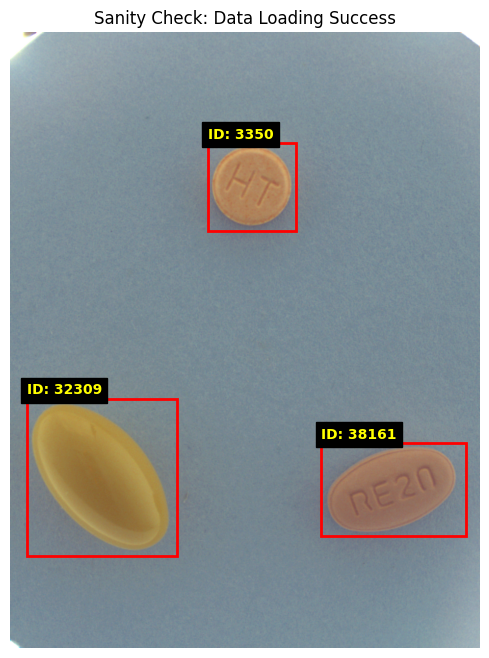

In [ ]:
import matplotlib.patches as patches

def check_data_connection(json_path, img_dir):
    print(f"🕵️ 데이터 연결 테스트 중... ({json_path})")

    # 1. JSON 로드
    if not os.path.exists(json_path):
        print("❌ JSON 파일이 없습니다!")
        return

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 2. 랜덤으로 이미지 하나 선택
    import random
    if not data['images']:
        print("❌ JSON에 이미지 정보가 없습니다.")
        return

    img_info = random.choice(data['images'])
    file_name = img_info['file_name']
    img_id = img_info['id']

    # 3. 이미지 읽기
    img_path = os.path.join(img_dir, file_name)
    if not os.path.exists(img_path):
        print(f"❌ 이미지 파일이 없습니다: {img_path}")
        return

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 4. 박스(Annotation) 매칭
    anns = [ann for ann in data['annotations'] if ann['image_id'] == img_id]

    # 5. 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    print(f"✅ 연결 성공! 파일명: {file_name}")
    print(f"💊 알약 개수: {len(anns)}개")

    for ann in anns:
        x, y, w, h = ann['bbox']
        category_id = ann['category_id']

        # 박스 그리기
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y-10, f"ID: {category_id}", color='yellow', weight='bold', backgroundcolor='black')

    plt.axis('off')
    plt.title("Sanity Check: Data Loading Success")
    plt.show()

# 실행
check_data_connection(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR)

## **3. 데이터 탐색**
- 목표: 56종 알약 중 '서비스 타겟 30종' 선정 및 데이터 리스트 확보

### **3.1 데이터 로드 및 ID-Name 매핑**

In [ ]:
import json
import os
import pandas as pd
from collections import Counter

# 1. JSON 파일 로드
print(f"📂 데이터 로드 중... ({Config.TRAIN_JSON})")
with open(Config.TRAIN_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. ID <-> 약 정보 매핑 (Dictionary 생성)
pill_info_map = {}

for cat in data['categories']:
    pill_info_map[cat['id']] = {
        'name': cat['name'],               # 약 이름
        'company': cat.get('dl_company', ''), # 제조사
        'material': cat.get('dl_material', '') # 성분 (서비스 핵심 정보!)
    }

print(f"✅ 매핑 완료! 총 {len(pill_info_map)}개의 알약 정보를 확보했습니다.")
# 테스트로 첫 번째 알약 정보 출력해보기
first_id = list(pill_info_map.keys())[0]
print(f"🔎 예시 (ID {first_id}): {pill_info_map[first_id]}")

📂 데이터 로드 중... (./data/train.json)
✅ 매핑 완료! 총 56개의 알약 정보를 확보했습니다.
🔎 예시 (ID 16687): {'name': '오마코연질캡슐(오메가-3-산에틸에스테르90)', 'company': '', 'material': ''}


### **3.2 클래스 분포 확인**
- 가장 데이터가 많은 약 30개를 추출

In [ ]:
# 1. 알약 등장 횟수 세기 (Annotations 카운트)
# 이미지 속에 어떤 알약(category_id)이 몇 번 나왔는지 셉니다.
pill_counts = Counter([ann['category_id'] for ann in data['annotations']])

# 2. 분석용 데이터프레임(표) 생성
df = pd.DataFrame.from_dict(pill_counts, orient='index', columns=['count'])
df.index.name = 'class_id'
df.reset_index(inplace=True)

# 3. 아까 만든 'pill_info_map'을 이용해 이름과 성분 채워 넣기
df['pill_name'] = df['class_id'].map(lambda x: pill_info_map.get(x, {}).get('name', 'Unknown'))
df['company'] = df['class_id'].map(lambda x: pill_info_map.get(x, {}).get('company', 'Unknown'))
df['material'] = df['class_id'].map(lambda x: pill_info_map.get(x, {}).get('material', 'Unknown'))

# 4. 개수 많은 순서로 정렬 (내림차순)
df = df.sort_values(by='count', ascending=False).reset_index(drop=True)

# 5. [핵심] 서비스 타겟 Top 30 추출 및 저장
top30_df = df.head(30)
save_csv_path = './top30_pills_service.csv'

# 엑셀에서 한글 깨짐 방지를 위해 'utf-8-sig' 인코딩으로 저장
top30_df.to_csv(save_csv_path, index=False, encoding='utf-8-sig')

print("-" * 50)
print(f"💾 [서비스용 파일 저장 완료] {save_csv_path}")
print("👉 코랩 왼쪽 파일 폴더에서 이 파일을 다운로드해서 팀원들과 공유하세요!")
print("-" * 50)
print("🏆 [데이터 수량 Top 10 알약]")
print(top30_df[['class_id', 'pill_name', 'count', 'company']].head(10).to_string(index=False))

--------------------------------------------------
💾 [서비스용 파일 저장 완료] ./top30_pills_service.csv
👉 코랩 왼쪽 파일 폴더에서 이 파일을 다운로드해서 팀원들과 공유하세요!
--------------------------------------------------
🏆 [데이터 수량 Top 10 알약]
 class_id          pill_name  count company
     3350        일양하이트린정 2mg    240        
     3482 기넥신에프정(은행엽엑스)(수출용)     45        
    35205       아토젯정 10/40mg     40        
    16261         크레스토정 20mg     31        
    20237         플라빅스정 75mg     29        
    29666           리바로정 4mg     29        
    16231          리피토정 20mg     29        
     3831       뉴로메드정(옥시라세탐)     27        
    38161     로수바미브정 10/20mg     27        
    22073         리피로우정 20mg     26        


### **3.3 원본 데이터 시각화**

/tmp/ipython-input-2120358040.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top30_df, y='pill_name', x='count', palette='viridis')


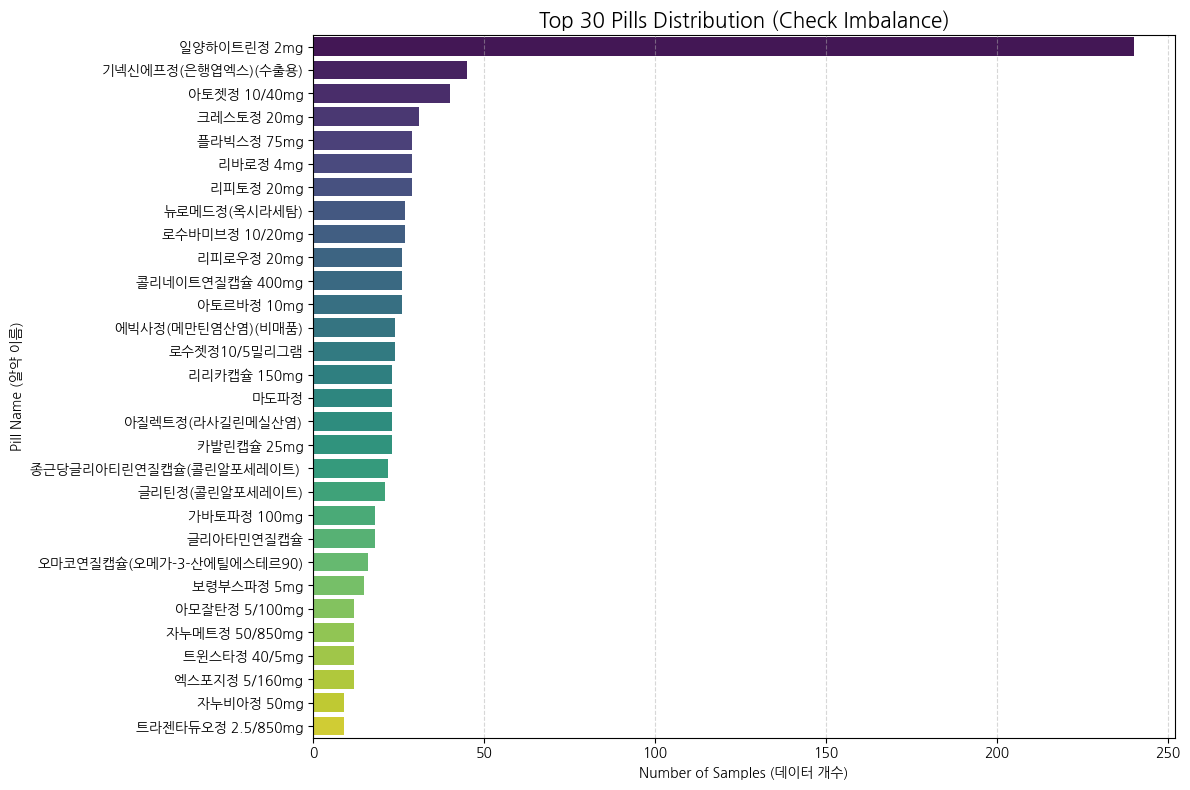

📊 그래프 해석 팁:
1. 그래프가 완만하게 줄어들면: 데이터 밸런스가 좋은 편입니다.
2. 'L'자 처럼 급격히 줄어들면: 데이터 불균형이 심하므로, 적은 데이터는 증강(Augmentation)이 필수입니다.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화 설정
plt.figure(figsize=(12, 8))

# 막대 그래프 그리기 (x: 개수, y: 약 이름)
sns.barplot(data=top30_df, y='pill_name', x='count', palette='viridis')

plt.title("Top 30 Pills Distribution (Check Imbalance)", fontsize=15)
plt.xlabel("Number of Samples (데이터 개수)")
plt.ylabel("Pill Name (알약 이름)")
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 그래프 출력
plt.tight_layout()
plt.show()

print("📊 그래프 해석 팁:")
print("1. 그래프가 완만하게 줄어들면: 데이터 밸런스가 좋은 편입니다.")
print("2. 'L'자 처럼 급격히 줄어들면: 데이터 불균형이 심하므로, 적은 데이터는 증강(Augmentation)이 필수입니다.")

### **3.4 부족한 데이터 확인**

In [ ]:
import json
from collections import Counter

# 설정: 이 개수보다 적으면 가져와야 함
MIN_COUNT = 50

# 현재 데이터 로드
CURRENT_JSON = './data/train_final.json'

with open(CURRENT_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 개수 세기
cat_map = {cat['id']: cat['name'] for cat in data['categories']}
cnt = Counter([ann['category_id'] for ann in data['annotations']])

print(f"📋 [AI Hub 쇼핑 리스트] (기준: {MIN_COUNT}개 미만)")
print("-" * 40)

target_pills = []
for cat_id, name in cat_map.items():
    count = cnt[cat_id]
    if count < MIN_COUNT:
        needed = MIN_COUNT - count
        print(f"🔴 부족: '{name}' (현재 {count}개 -> {needed}개 더 필요)")
        target_pills.append(name)

print("-" * 40)
if not target_pills:
    print("✅ 모든 약이 충분합니다! AI Hub 갈 필요 없습니다.")
else:
    print(f"👉 총 {len(target_pills)}종류의 약을 AI Hub에서 찾아오세요!")
    print(f"💡 팁: AI Hub 데이터 압축 풀고, 위 이름으로 검색해서 그 폴더만 복사해오면 됩니다.")

📋 [AI Hub 쇼핑 리스트] (기준: 50개 미만)
----------------------------------------
🔴 부족: '오마코연질캡슐(오메가-3-산에틸에스테르90)' (현재 8개 -> 42개 더 필요)
🔴 부족: '리리카캡슐 150mg' (현재 15개 -> 35개 더 필요)
🔴 부족: '아질렉트정(라사길린메실산염)' (현재 12개 -> 38개 더 필요)
🔴 부족: '로수바미브정 10/20mg' (현재 18개 -> 32개 더 필요)
🔴 부족: '마도파정' (현재 16개 -> 34개 더 필요)
🔴 부족: '크레스토정 20mg' (현재 23개 -> 27개 더 필요)
🔴 부족: '글리틴정(콜린알포세레이트)' (현재 16개 -> 34개 더 필요)
🔴 부족: '자누비아정 50mg' (현재 9개 -> 41개 더 필요)
🔴 부족: '트윈스타정 40/5mg' (현재 12개 -> 38개 더 필요)
🔴 부족: '기넥신에프정(은행엽엑스)(수출용)' (현재 45개 -> 5개 더 필요)
🔴 부족: '로수젯정10/5밀리그램' (현재 19개 -> 31개 더 필요)
🔴 부족: '에빅사정(메만틴염산염)(비매품)' (현재 15개 -> 35개 더 필요)
🔴 부족: '노바스크정 5mg' (현재 6개 -> 44개 더 필요)
🔴 부족: '트라젠타정(리나글립틴)' (현재 9개 -> 41개 더 필요)
🔴 부족: '자누메트정 50/850mg' (현재 12개 -> 38개 더 필요)
🔴 부족: '리바로정 4mg' (현재 18개 -> 32개 더 필요)
🔴 부족: '카발린캡슐 25mg' (현재 16개 -> 34개 더 필요)
🔴 부족: '글리아타민연질캡슐' (현재 14개 -> 36개 더 필요)
🔴 부족: '플라빅스정 75mg' (현재 20개 -> 30개 더 필요)
🔴 부족: '뉴로메드정(옥시라세탐)' (현재 20개 -> 30개 더 필요)
🔴 부족: '아토르바정 10mg' (현재 22개 -> 28개 더 필요)
🔴 부족: '뮤테란캡슐 100mg' (현재 9개 -> 41개 더 필요)
🔴 부족: '큐

### **3.5 데이터 증강**

[데이터 불균형 해결 전략: Offline Data Augmentation]

**1. 문제 상황 (Problem)**

- 전체 56개 클래스 중 55개가 데이터 부족(50개 미만) 상태였으며, 심각한 경우 3~5장에 불과함 (Long-tail Distribution).

- 외부 데이터(AI Hub 원천 데이터) 사용이 대회 규정상 제한됨(Data Contamination 방지).

- 웹 크롤링 데이터는 라벨(Bounding Box)이 없어 오토라벨링의 정확도를 보장할 수 없음.

**2. 해결 전략 (Solution)**

- Offline Augmentation (자가 증식) 도입: 기존의 실시간 증강(On-the-fly) 방식과 달리, 데이터를 물리적으로 생성하여 저장하는 방식을 채택.

- Safe Transformation 기술 적용: 회전(Rotate) 시 객체가 잘리는 문제를 방지하기 위해 SafeRotate 및 Retry Logic(재시도 로직)을 구현하여 100% 무결한 데이터만 생성.

**3. 기대 효과 (Effect)**

- 모든 클래스의 최소 데이터 수를 50개 이상으로 맞춰 클래스 불균형 완벽 해소.

- 외부 데이터 없이도 모델의 강건성(Robustness) 확보.

- 모델이 학습 과정에서 빈번하게 정답을 보게 되어 수렴 속도 및 mAP 향상 기대.

In [ ]:
import json
import os
import cv2
import shutil
import numpy as np
from tqdm import tqdm
from collections import Counter
import albumentations as A
import random

# 1. 설정 및 필터링 완화 (박스 생존율 UP ⭐)
CURRENT_JSON_PATH = './data/train_final.json'
CURRENT_IMG_DIR = './data/train_images'
TARGET_COUNT = 50

# ✅ [수정] 박스 삭제 조건 대폭 완화
augmentor = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=180,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
    A.GaussianBlur(blur_limit=(3, 5), p=0.4),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.4),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
], bbox_params=A.BboxParams(
    format='coco',
    label_fields=['category_ids'],
    min_visibility=0.1, # ⭐ 0.7 -> 0.1 (10%만 보여도 박스 유지! 절대 삭제 안 함)
    min_area=0          # ⭐ 크기 제한 없음 (작아도 살림)
))

# 2. 데이터 초기화 (Reset)
print("🔄 데이터셋 초기화 및 복구 중...")

with open(CURRENT_JSON_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 'aug_' 제거하고 원본만 남김
clean_images = [img for img in data['images'] if not img['file_name'].startswith('aug_')]
clean_img_ids = set(img['id'] for img in clean_images)
clean_annotations = [ann for ann in data['annotations'] if ann['image_id'] in clean_img_ids]

data['images'] = clean_images
data['annotations'] = clean_annotations

print(f"   - 원본 복구 완료: {len(clean_images)}장")

# 3. 부족한 클래스 식별
curr_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}
img_info_map = {img['id']: img for img in data['images']}

img_to_anns = {}
for ann in data['annotations']:
    img_id = ann['image_id']
    if img_id not in img_to_anns: img_to_anns[img_id] = []
    img_to_anns[img_id].append(ann)

cat_cnt = Counter([ann['category_id'] for ann in data['annotations']])
target_cats = {cid: TARGET_COUNT - cnt for cid, cnt in cat_cnt.items() if cnt < TARGET_COUNT}

print(f"📉 총 {len(target_cats)}개 클래스 증식 시작 (조건: min_visibility=0.1)")

# 4. 데이터 자가 증식 (강력한 Retry)
next_img_id = max([img['id'] for img in data['images']]) + 10000
next_ann_id = max([ann['id'] for ann in data['annotations']]) + 10000
generated_count = 0
failed_count = 0

for cat_id, needed in tqdm(target_cats.items(), desc="🧬 증식 중"):

    source_img_ids = [ann['image_id'] for ann in data['annotations'] if ann['category_id'] == cat_id]
    valid_source_ids = [img_id for img_id in source_img_ids if img_id in img_info_map]

    if not valid_source_ids: continue

    for i in range(needed):
        retry_count = 0
        success = False

        # 🔄 최대 20번 재시도
        while retry_count < 20:
            src_img_id = random.choice(valid_source_ids)
            src_info = img_info_map[src_img_id]
            src_path = os.path.join(CURRENT_IMG_DIR, src_info['file_name'])

            image = cv2.imread(src_path)
            if image is None:
                retry_count += 1
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            anns = img_to_anns.get(src_img_id, [])
            bboxes = [a['bbox'] for a in anns]
            cat_ids = [a['category_id'] for a in anns]

            # 박스 없으면 스킵
            if len(bboxes) == 0:
                retry_count += 1
                continue

            try:
                transformed = augmentor(image=image, bboxes=bboxes, category_ids=cat_ids)
                aug_img = transformed['image']
                aug_bboxes = transformed['bboxes']

                # ⭐ 박스가 하나라도 있으면 저장 (조건 대폭 완화됨)
                if len(aug_bboxes) > 0:
                    new_filename = f"aug_{cat_id}_{i}_{src_info['file_name']}"
                    dst_path = os.path.join(CURRENT_IMG_DIR, new_filename)
                    cv2.imwrite(dst_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

                    new_img_info = src_info.copy()
                    new_img_info['id'] = next_img_id
                    new_img_info['file_name'] = new_filename
                    data['images'].append(new_img_info)

                    for bbox, cid in zip(aug_bboxes, cat_ids):
                        # 박스 좌표 음수 방지 (안전장치)
                        x, y, w, h = bbox
                        x = max(0, x)
                        y = max(0, y)

                        new_ann = {
                            "id": next_ann_id,
                            "image_id": next_img_id,
                            "category_id": cid,
                            "bbox": [x, y, w, h],
                            "area": w * h,
                            "iscrowd": 0
                        }
                        data['annotations'].append(new_ann)
                        next_ann_id += 1

                    next_img_id += 1
                    generated_count += 1
                    success = True
                    break

            except Exception:
                pass

            retry_count += 1

        if not success:
            failed_count += 1

# 5. 결과 저장
FINAL_OUTPUT = './data/train_final_augmented.json'
with open(FINAL_OUTPUT, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False)

Config.TRAIN_JSON = FINAL_OUTPUT

print("-" * 50)
print(f"✨ 증식 완료 (박스 생존율 최우선 적용)")
print(f"🧬 생성된 이미지: {generated_count}장")
print(f"💾 최종 데이터셋: {FINAL_OUTPUT}")
print("-" * 50)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3690223388.py:20: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-3690223388.py:33: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


🔄 데이터셋 초기화 및 복구 중...
   - 원본 복구 완료: 232장
📉 총 55개 클래스 증식 시작 (조건: min_visibility=0.1)


🧬 증식 중: 100%|██████████| 55/55 [06:32<00:00,  7.13s/it]


--------------------------------------------------
✨ 증식 완료 (박스 생존율 최우선 적용)
🧬 생성된 이미지: 2140장
💾 최종 데이터셋: ./data/train_final_augmented.json
--------------------------------------------------


### **3.6 증강 데이터 시각화 검증 (이미지 & 그래프)**

🔎 검증 시작: 총 2140장의 증강 이미지가 발견되었습니다.


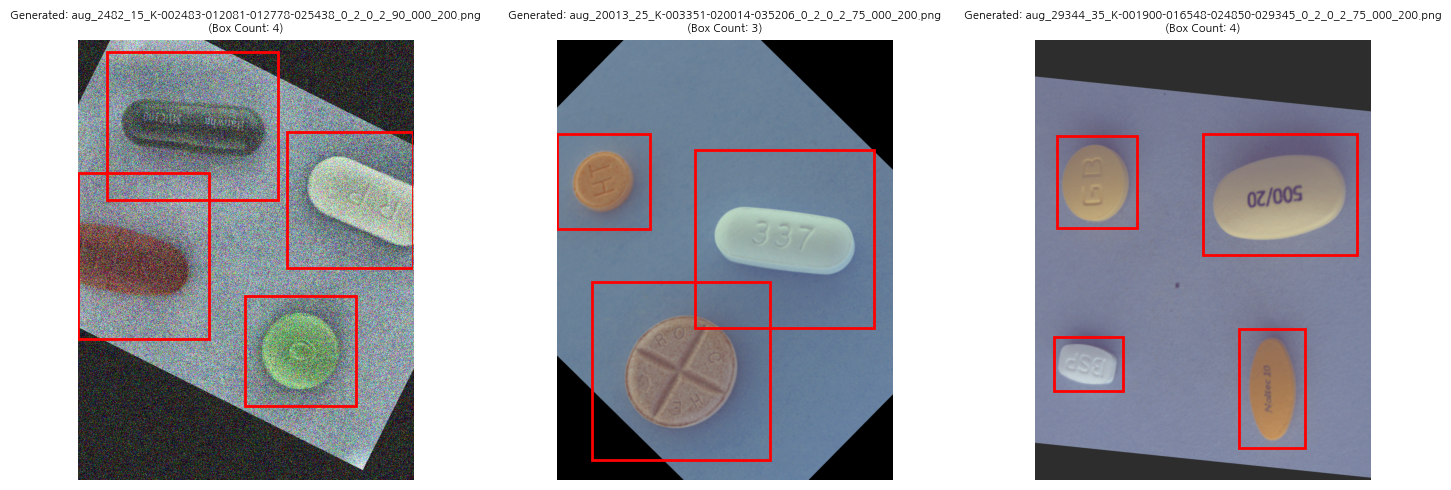

✅ 확인 포인트: 이미지가 회전/변형되었는데도 빨간 박스가 알약을 잘 감싸고 있나요?


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import os
import random
from PIL import Image

# 1. 방금 만든 증강 데이터셋 로드
AUGMENTED_JSON = './data/train_final_augmented.json'
IMG_DIR = './data/train_images'

with open(AUGMENTED_JSON, 'r') as f:
    data = json.load(f)

# 2. "새로 만든 이미지(aug_)"만 골라내기
aug_images = [img for img in data['images'] if 'aug_' in img['file_name']]

print(f"🔎 검증 시작: 총 {len(aug_images)}장의 증강 이미지가 발견되었습니다.")

# 3. 랜덤으로 3장 뽑아서 시각화
if len(aug_images) > 0:
    samples = random.sample(aug_images, min(3, len(aug_images)))

    # ID로 어노테이션 찾기 편하게 매핑
    img_to_anns = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_anns: img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)

    plt.figure(figsize=(15, 5))

    for i, img_info in enumerate(samples):
        img_path = os.path.join(IMG_DIR, img_info['file_name'])

        if os.path.exists(img_path):
            # 이미지 열기
            image = Image.open(img_path)
            ax = plt.subplot(1, 3, i + 1)
            ax.imshow(image)

            # 박스 그리기
            anns = img_to_anns.get(img_info['id'], [])
            for ann in anns:
                x, y, w, h = ann['bbox']
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

            ax.set_title(f"Generated: {img_info['file_name']}\n(Box Count: {len(anns)})", fontsize=8)
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    print("✅ 확인 포인트: 이미지가 회전/변형되었는데도 빨간 박스가 알약을 잘 감싸고 있나요?")
else:
    print("⚠️ 증강된 이미지가 없습니다. 코드가 제대로 실행됐는지 확인하세요.")

📂 데이터 로드 중... (./data/train_final_augmented.json)


/tmp/ipython-input-1415239594.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_augmented, x='count', y='pill_name', palette='viridis')


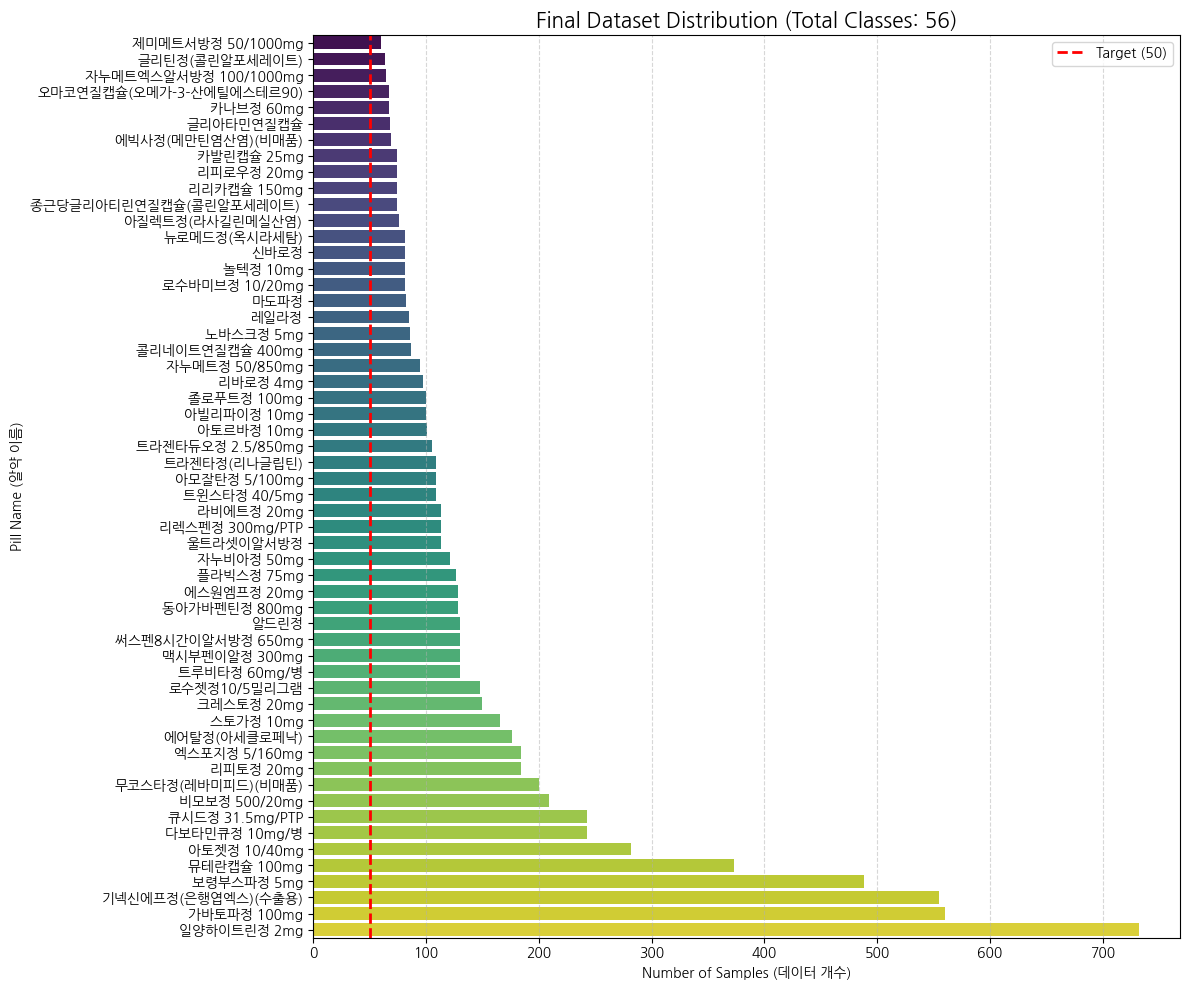

📊 [검증 결과]
   - 총 클래스 개수: 56개
   - 최소 데이터 개수: 60개 (이게 50 이상이어야 성공!)
   - 최대 데이터 개수: 732개


In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# 1. 증강된 최종 데이터셋 로드
AUGMENTED_JSON = './data/train_final_augmented.json' # 방금 만든 파일

print(f"📂 데이터 로드 중... ({AUGMENTED_JSON})")
with open(AUGMENTED_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. 개수 다시 세기 (Re-counting)
# ID <-> 이름 매핑
id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# 어노테이션에서 카테고리 ID 추출해서 세기
cnt = Counter([ann['category_id'] for ann in data['annotations']])

# 데이터프레임으로 변환
stats = []
for cat_id, count in cnt.items():
    stats.append({
        'pill_name': id_to_name[cat_id],
        'count': count
    })

df_augmented = pd.DataFrame(stats)

# 보기 좋게 정렬 (적은 순서대로 보거나, 많은 순서대로)
df_augmented = df_augmented.sort_values(by='count', ascending=True)

# 3. 시각화 (Before vs After 효과 확인)
plt.figure(figsize=(12, 10)) # 세로로 긴 그래프가 보기 편함

# 막대 그래프 (수평)
sns.barplot(data=df_augmented, x='count', y='pill_name', palette='viridis')

# 기준선(50개) 그리기
plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Target (50)')

plt.title(f"Final Dataset Distribution (Total Classes: {len(df_augmented)})", fontsize=15)
plt.xlabel("Number of Samples (데이터 개수)")
plt.ylabel("Pill Name (알약 이름)")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 텍스트로도 요약 출력
print("📊 [검증 결과]")
print(f"   - 총 클래스 개수: {len(df_augmented)}개")
print(f"   - 최소 데이터 개수: {df_augmented['count'].min()}개 (이게 50 이상이어야 성공!)")
print(f"   - 최대 데이터 개수: {df_augmented['count'].max()}개")

## **4. 데이터 전처리 & 데이터셋 구축**

### **4.1 데이터 클리닝**
- 유령 데이터(이미지 파일이 없는 경우)를 JSON에서 영구 제거하고 train_finam.json 생성

In [ ]:
import os
import json

def clean_and_update_config():
    print("데이터 클리닝 시작...")

    # 1. 기존 JSON 로드
    with open(Config.TRAIN_JSON, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 2. 실제 파일 목록 스캔
    existing_files = set(os.listdir(Config.TRAIN_IMG_DIR))
    print(f"   📂 폴더 내 실제 파일 수: {len(existing_files)}개")

    # 3. 유효 데이터 필터링
    valid_images = []
    valid_img_ids = set()

    for img in data['images']:
        if img['file_name'] in existing_files:
            valid_images.append(img)
            valid_img_ids.add(img['id'])

    # 이미지 ID가 살아남은 경우만 어노테이션도 유지
    valid_annotations = [ann for ann in data['annotations'] if ann['image_id'] in valid_img_ids]

    # 4. 결과 저장
    cleaned_data = {
        "images": valid_images,
        "annotations": valid_annotations,
        "categories": data['categories']
    }

    # 새로운 파일명으로 저장 (덮어쓰기 방지)
    clean_path = os.path.join(Config.DATA_ROOT, 'train_final.json')
    with open(clean_path, 'w', encoding='utf-8') as f:
        json.dump(cleaned_data, f, ensure_ascii=False)

    # 5. Config 경로 영구 업데이트
    Config.TRAIN_JSON = clean_path

    print(f"   ✨ 클리닝 완료! 제거된 유령 데이터: {len(data['images']) - len(valid_images)}건")
    print(f"   ✅ 최종 학습 데이터 경로 업데이트: {Config.TRAIN_JSON}")

# 실행
if os.path.exists(Config.TRAIN_JSON):
    clean_and_update_config()
else:
    print("❌ train.json이 없습니다. 2.4단계를 확인하세요.")

데이터 클리닝 시작...
   📂 폴더 내 실제 파일 수: 7665개
   ✨ 클리닝 완료! 제거된 유령 데이터: 0건
   ✅ 최종 학습 데이터 경로 업데이트: ./data/train_final.json


### **4.2 전처리 전략 수립**
- 약 봉지 상황 대응
- 약 봉지 속 알약 상황 구현을 위해서는 바운딩 박스도 같이 회전해야 함. 그래서 Albumentation 라이브러리로 해결.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. 학습용 (Train): 약 봉지 시뮬레이션 완결판
train_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),

    # (1) 회전: 봉지 안에서 굴러다님
    A.Rotate(limit=180, p=0.7),

    # (2) 반전: 앞뒤 구분 모호함
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    # (3) [New] 비닐 질감 시뮬레이션 ⭐
    # Blur: 비닐 때문에 뿌옇게 보이는 현상
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    # CLAHE: 비닐 난반사로 인한 국소적 대비 변화
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),

    # (4) 조명 변화 (기존 유지)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

# 2. 검증용 (Valid): 원본 유지
val_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

### **4.3 데이터셋 및 로더 구현**
- 데이터 수가 너무 적어서 9:1로 구현

In [ ]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset

# 1. Dataset 클래스 정의
class PillDataset(Dataset):
    def __init__(self, json_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(json_path, 'r') as f:
            self.coco = json.load(f)
        self.img_id_to_ann = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_ann: self.img_id_to_ann[img_id] = []
            self.img_id_to_ann[img_id].append(ann)
        self.images = self.coco['images']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        file_name = img_info['file_name']
        img_id = img_info['id']
        img_path = os.path.join(self.img_dir, file_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        anns = self.img_id_to_ann.get(img_id, [])
        boxes, category_ids = [], []
        for ann in anns:
            x, y, w, h = ann['bbox']
            if w > 1 and h > 1:
                boxes.append([x, y, w, h])
                category_ids.append(ann['category_id'])

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, category_ids=category_ids)
            image_tensor = transformed['image']
            boxes = transformed['bboxes']
            category_ids = transformed['category_ids']
        else:
            image_tensor = ToTensorV2()(image=image)['image']

        target = {}
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            # COCO(xywh) -> Pascal VOC(xyxy) 변환
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            target['boxes'] = boxes
            target['labels'] = torch.tensor(category_ids, dtype=torch.int64)
        else:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros((0), dtype=torch.int64)

        target['image_id'] = torch.tensor([img_id])
        return image_tensor, target

def collate_fn(batch): return tuple(zip(*batch))

# 2. 데이터 분할 및 로더 생성 (8:2)
print("데이터 로더 생성 중...")
full_dataset = PillDataset(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR)
indices = torch.randperm(len(full_dataset)).tolist()

train_size = int(len(full_dataset) * 0.8)
train_indices = indices[:train_size]
valid_indices = indices[train_size:]

train_dataset = Subset(PillDataset(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR, transform=train_transform), train_indices)
valid_dataset = Subset(PillDataset(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR, transform=val_transform), valid_indices)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, collate_fn=collate_fn)

print(f"생성 완료: Train({len(train_dataset)}장), Valid({len(valid_dataset)}장)")

데이터 로더 생성 중...
생성 완료: Train(1897장), Valid(475장)


### **4.4 파이프라인 최종 검증**

파이프라인 최종 검증


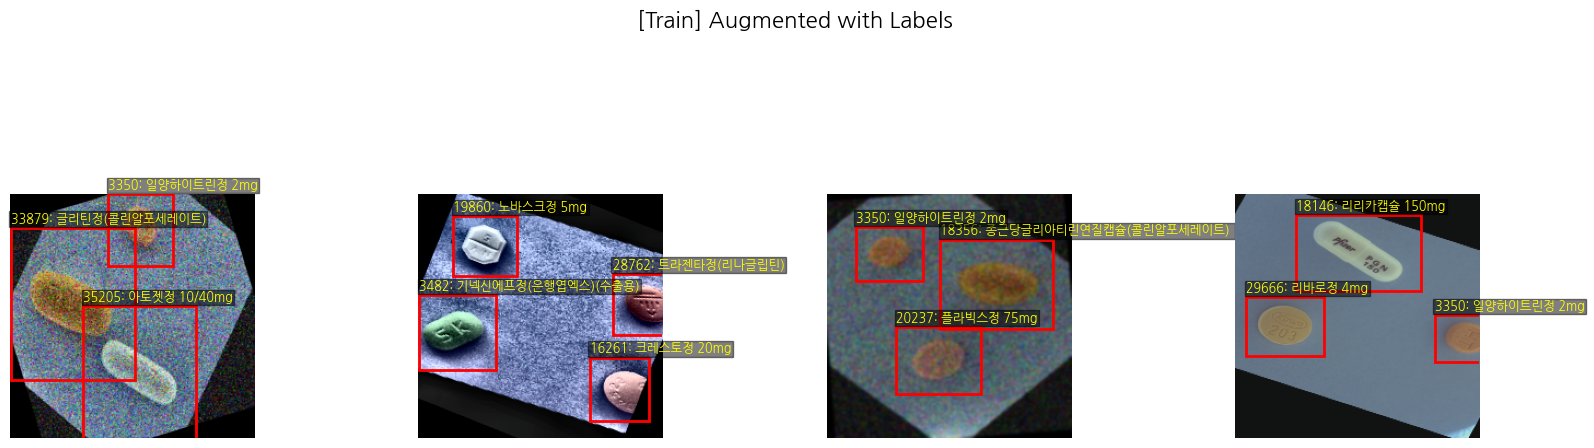

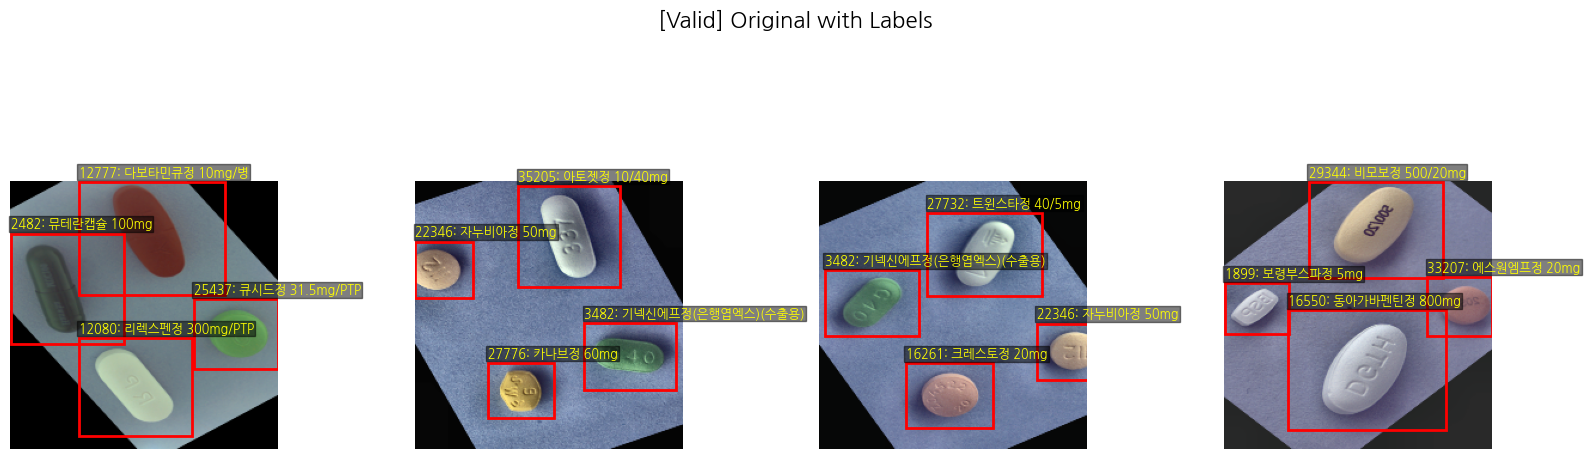

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

# 1. 약 이름 매핑 정보 로드 (이름을 띄우기 위해)
with open(Config.TRAIN_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)
    # ID -> Name 매핑 사전 생성
    id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# 2. 시각화 함수
def visualize_check_with_labels(loader, title):
    try:
        images, targets = next(iter(loader))
    except StopIteration:
        print("❌ 로더가 비어있습니다.")
        return

    plt.figure(figsize=(16, 6))

    # 4장만 샘플링
    for i in range(min(4, len(images))):
        # 이미지 역정규화
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(img)

        if 'boxes' in targets[i] and len(targets[i]['boxes']) > 0:
            for j, box in enumerate(targets[i]['boxes']):
                x1, y1, x2, y2 = box.numpy()
                class_id = targets[i]['labels'][j].item()
                pill_name = id_to_name.get(class_id, "Unknown")

                # (1) 빨간 박스
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

                # (2) 텍스트 라벨 (ID + 이름)
                # 글자가 잘 보이게 검은 배경에 노란 글씨로 출력
                label_text = f"{class_id}: {pill_name}"
                plt.text(x1, y1-5, label_text, color='yellow', fontsize=9, fontweight='bold',
                         bbox=dict(facecolor='black', alpha=0.5, pad=1))

        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 실행
print("파이프라인 최종 검증")
visualize_check_with_labels(train_loader, "[Train] Augmented with Labels")
visualize_check_with_labels(valid_loader, "[Valid] Original with Labels")

In [ ]:
import shutil
import os
import glob

# 1. 백업 루트 경로
BACKUP_ROOT = '/content/drive/MyDrive/My_AI_Project/backup_data'

# 2. 가장 최근 백업 폴더 자동 찾기
# 'augmented_backup_'으로 시작하는 폴더들을 찾아서 정렬합니다.
backup_candidates = sorted(glob.glob(os.path.join(BACKUP_ROOT, 'augmented_backup_*')))

if len(backup_candidates) == 0:
    print("❌ 오류: 드라이브에 백업된 폴더가 하나도 없습니다!")
    print(f"   (확인 경로: {BACKUP_ROOT})")
else:
    # 맨 마지막 것이 가장 최신입니다.
    LATEST_BACKUP_DIR = backup_candidates[-1]
    print(f"✅ 최신 백업 폴더를 찾았습니다: {os.path.basename(LATEST_BACKUP_DIR)}")

    DATA_ROOT = './data'
    TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')

    # 폴더 생성
    if not os.path.exists(DATA_ROOT):
        os.makedirs(DATA_ROOT)

    # (혹시 모르니 이미지 폴더가 있으면 비우고 새로 만듦)
    if os.path.exists(TRAIN_IMG_DIR):
        shutil.rmtree(TRAIN_IMG_DIR)
    os.makedirs(TRAIN_IMG_DIR)

    print("♻️ 데이터 복구 시작...")

    # 3. JSON 복구
    src_json = os.path.join(LATEST_BACKUP_DIR, 'train_final_augmented.json')
    dst_json = os.path.join(DATA_ROOT, 'train_final_augmented.json')

    if os.path.exists(src_json):
        shutil.copy(src_json, dst_json)
        print("   ✅ JSON 파일 복구 완료")
    else:
        print("   ⚠️ JSON 파일이 백업 폴더에 없습니다!")

    # 4. 이미지 압축 해제
    zip_path = os.path.join(LATEST_BACKUP_DIR, 'train_images.zip')

    if os.path.exists(zip_path):
        print("   📦 이미지 압축 해제 중... (잠시만 기다려주세요)")
        # zip 파일 안의 내용물을 target 폴더에 풉니다.
        shutil.unpack_archive(zip_path, TRAIN_IMG_DIR)
        print("   ✅ 이미지 복구 완료")
    else:
        print("   ⚠️ 이미지 zip 파일이 백업 폴더에 없습니다!")

    print("-" * 30)
    print("🎉 복구 작업이 끝났습니다. 이제 5단계(모델 학습)로 넘어가세요!")

✅ 최신 백업 폴더를 찾았습니다: augmented_backup_1210_1014
♻️ 데이터 복구 시작...
   ✅ JSON 파일 복구 완료
   📦 이미지 압축 해제 중... (잠시만 기다려주세요)
   ✅ 이미지 복구 완료
------------------------------
🎉 복구 작업이 끝났습니다. 이제 5단계(모델 학습)로 넘어가세요!


## **5. 모델 구축 및 학습**

### **5.1 모델 선정**

### **5.2 학습 루프 구현 및 실행**

## **6. 모델 학습**

## **7. 결론 및 정리**